DQN

Episode 1/20000, Total Reward: -24, Epsilon: 0.99
Episode 2/20000, Total Reward: -204, Epsilon: 0.99
Episode 3/20000, Total Reward: -178, Epsilon: 0.99
Episode 4/20000, Total Reward: -117, Epsilon: 0.98
Episode 5/20000, Total Reward: -68, Epsilon: 0.98
Episode 6/20000, Total Reward: -11, Epsilon: 0.97
Episode 7/20000, Total Reward: -34, Epsilon: 0.97
Episode 8/20000, Total Reward: -84, Epsilon: 0.96
Episode 9/20000, Total Reward: -42, Epsilon: 0.96
Episode 10/20000, Total Reward: -85, Epsilon: 0.95
Episode 11/20000, Total Reward: -46, Epsilon: 0.95
Episode 12/20000, Total Reward: -106, Epsilon: 0.94
Episode 13/20000, Total Reward: -55, Epsilon: 0.94
Episode 14/20000, Total Reward: -18, Epsilon: 0.93
Episode 15/20000, Total Reward: -36, Epsilon: 0.93
Episode 16/20000, Total Reward: -56, Epsilon: 0.92
Episode 17/20000, Total Reward: -78, Epsilon: 0.92
Episode 18/20000, Total Reward: -79, Epsilon: 0.91
Episode 19/20000, Total Reward: -134, Epsilon: 0.91
Episode 20/20000, Total Reward: -31

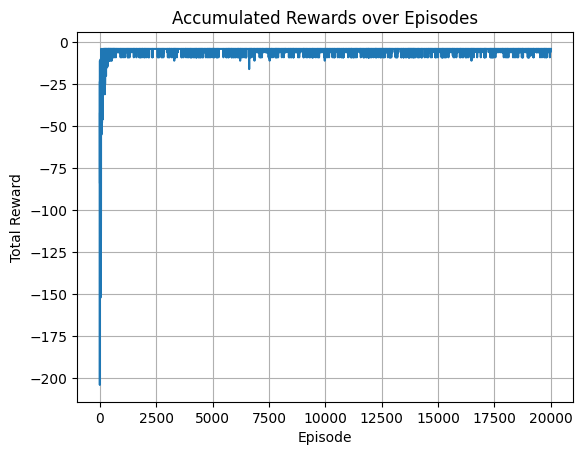

In [7]:
import torch
import torch.nn as nn
import random
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt 

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Enhanced UAV Environment
class EnhancedSmallUAVEnv:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        # Distance and direction to the goal from current position
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        # Update position
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]

        # Check if out of grid
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -5, False  # Negative reward for attempting to leave the grid

        # Update to new position
        self.position = new_position

        # Check if goal is reached
        if self.position == self.goal:
            return self.get_state(), 1, True  # Positive reward for reaching the goal

        return self.get_state(), -1, False  # Small negative reward for each step

# DQN Model
class FinalDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(FinalDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Training function with Experience Replay
def train_dqn_with_replay_v3(env, model, memory, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                             epsilon_decay=0.995, lr=0.01, max_steps=50, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        step_count = 0
        total_reward = 0

        while not done and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(num_actions))
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward

            # Store the transition in memory
            memory.push((state, action, reward, next_state, done))
            
            if len(memory) > batch_size:
                # Sample a random batch of transitions
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return episode_rewards

# Main Execution
memory = ReplayMemory(capacity=1000)
env = EnhancedSmallUAVEnv()
model = FinalDQN(input_dim=4, num_actions=4)
rewards = train_dqn_with_replay_v3(env, model, memory, episodes=20000, lr=0.001, max_steps=100)

# Using the provided plot_rewards function to visualize the accumulated rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Accumulated Rewards over Episodes')
    plt.grid(True)
    plt.show()

# Given that the training has been executed and the rewards list has been populated:
plot_rewards(rewards)



DQN

ENHANCED DQN-보상 조절

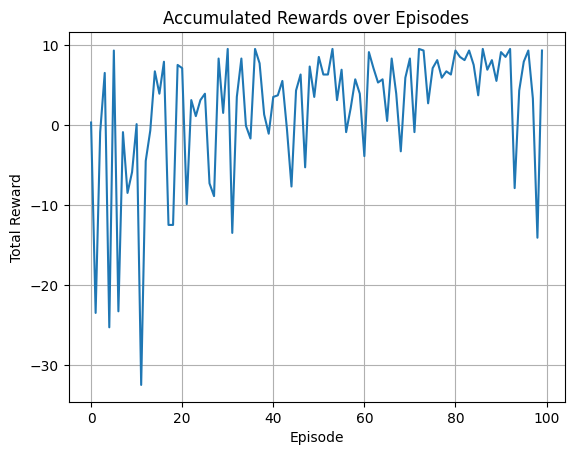

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt


# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Enhanced UAV Environment with Adjusted Reward Structure
class EnhancedSmallUAVEnvV3:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        # Distance and direction to the goal from current position
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        # Update position
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]

        # Check if out of grid
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -1, False

        # Update to new position
        self.position = new_position

        # Check if goal is reached
        if self.position == self.goal:
            return self.get_state(), 10, True

        return self.get_state(), -0.1, False

# DQN Model
class FinalDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(FinalDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Training function with Experience Replay
def train_dqn_with_replay_v3(env, model, memory, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                             epsilon_decay=0.995, lr=0.01, max_steps=50, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        step_count = 0
        total_reward = 0

        while not done and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(num_actions))
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward

            # Store the transition in memory
            memory.push((state, action, reward, next_state, done))
            
            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

    return episode_rewards

# Main Execution
memory = ReplayMemory(capacity=1000)
env_v3 = EnhancedSmallUAVEnvV3()
model_v3 = FinalDQN(input_dim=4, num_actions=4)
rewards_v3 = train_dqn_with_replay_v3(env_v3, model_v3, memory, episodes=100, lr=0.001, max_steps=100)
# Plot the accumulated rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Accumulated Rewards over Episodes')
    plt.grid(True)
    plt.show()

plot_rewards(rewards_v3)

ENHANCED DQN-보상 조절 (episode 1000)

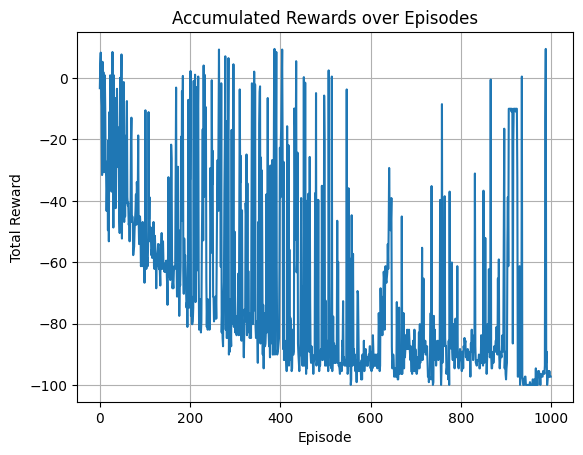

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt


# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Enhanced UAV Environment with Adjusted Reward Structure
class EnhancedSmallUAVEnvV3:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        # Distance and direction to the goal from current position
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        # Update position
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]

        # Check if out of grid
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -1, False

        # Update to new position
        self.position = new_position

        # Check if goal is reached
        if self.position == self.goal:
            return self.get_state(), 10, True

        return self.get_state(), -0.1, False

# DQN Model
class FinalDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(FinalDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Training function with Experience Replay
def train_dqn_with_replay_v3(env, model, memory, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                             epsilon_decay=0.995, lr=0.01, max_steps=50, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        step_count = 0
        total_reward = 0

        while not done and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(num_actions))
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward

            # Store the transition in memory
            memory.push((state, action, reward, next_state, done))
            
            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

    return episode_rewards

# Main Execution
memory = ReplayMemory(capacity=1000)
env_v3 = EnhancedSmallUAVEnvV3()
model_v3 = FinalDQN(input_dim=4, num_actions=4)
rewards_v3 = train_dqn_with_replay_v3(env_v3, model_v3, memory, episodes=1000, lr=0.001, max_steps=100)
# Plot the accumulated rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Accumulated Rewards over Episodes')
    plt.grid(True)
    plt.show()

plot_rewards(rewards_v3)

LEARNIGN RATE 0.0001

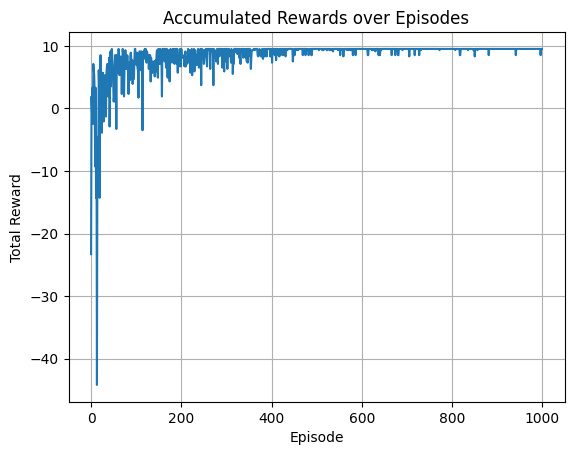

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd


# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Enhanced UAV Environment with Adjusted Reward Structure
class EnhancedSmallUAVEnvV3:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        # Distance and direction to the goal from current position
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        # Update position
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]

        # Check if out of grid
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -1, False

        # Update to new position
        self.position = new_position

        # Check if goal is reached
        if self.position == self.goal:
            return self.get_state(), 10, True

        return self.get_state(), -0.1, False

# DQN Model
class FinalDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(FinalDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Training function with Experience Replay
def train_dqn_with_replay_v3(env, model, memory, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                             epsilon_decay=0.995, lr=0.01, max_steps=50, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        step_count = 0
        total_reward = 0

        while not done and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(num_actions))
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward

            # Store the transition in memory
            memory.push((state, action, reward, next_state, done))
            
            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

    return episode_rewards

# Main Execution
memory = ReplayMemory(capacity=1000)
env_v3 = EnhancedSmallUAVEnvV3()
model_v3 = FinalDQN(input_dim=4, num_actions=4)
rewards_v3 = train_dqn_with_replay_v3(env_v3, model_v3, memory, episodes=1000, lr=0.0001, max_steps=100)
# Plot the accumulated rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Accumulated Rewards over Episodes')
    plt.grid(True)
    plt.show()

plot_rewards(rewards_v3)
rewards_df = pd.DataFrame(rewards, columns=['Reward'])
rewards_df.to_csv('4x4rewards_data.csv', index=False)

10x10 grid single UAV

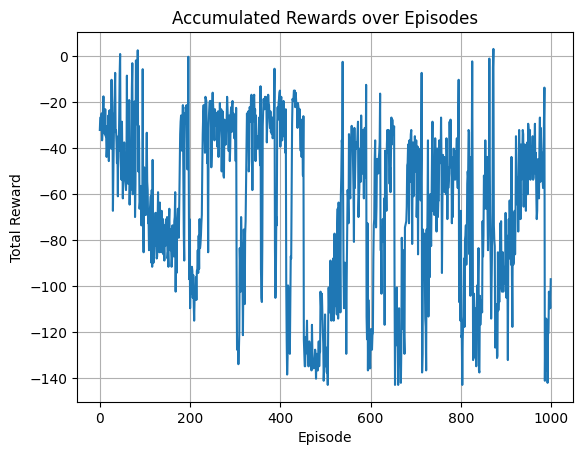

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# 10x10 UAV Environment
class LargeUAVEnv:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [9, 9]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 10  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -1, False
        self.position = new_position
        if self.position == self.goal:
            return self.get_state(), 10, True
        return self.get_state(), -0.1, False

# DQN Model
class FinalDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(FinalDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Training function with Experience Replay
def train_dqn_with_replay(env, model, memory, episodes=1000, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                          epsilon_decay=0.995, lr=0.001, max_steps=150, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        step_count = 0
        total_reward = 0

        while not done and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(num_actions))
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward
            memory.push((state, action, reward, next_state, done))

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

    return episode_rewards

# Main Execution
memory = ReplayMemory(capacity=1000)
env = LargeUAVEnv()
model = FinalDQN(input_dim=4, num_actions=4)
rewards = train_dqn_with_replay(env, model, memory, episodes=1000, lr=0.001, max_steps=150)

# Plot the rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Accumulated Rewards over Episodes')
    plt.grid(True)
    plt.show()

plot_rewards(rewards)


10x10 grid single UAV (lr=0.0001)

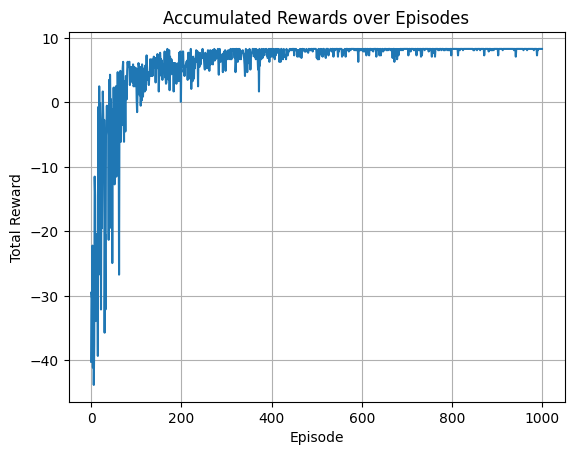

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# 10x10 UAV Environment
class LargeUAVEnv:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [9, 9]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 10  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -1, False
        self.position = new_position
        if self.position == self.goal:
            return self.get_state(), 10, True
        return self.get_state(), -0.1, False

# DQN Model
class FinalDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(FinalDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Training function with Experience Replay
def train_dqn_with_replay(env, model, memory, episodes=1000, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                          epsilon_decay=0.995, lr=0.001, max_steps=150, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        step_count = 0
        total_reward = 0

        while not done and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(num_actions))
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward
            memory.push((state, action, reward, next_state, done))

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

    return episode_rewards

# Main Execution
memory = ReplayMemory(capacity=1000)
env = LargeUAVEnv()
model = FinalDQN(input_dim=4, num_actions=4)
rewards = train_dqn_with_replay(env, model, memory, episodes=1000, lr=0.0001, max_steps=150)

# Plot the rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Accumulated Rewards over Episodes')
    plt.grid(True)
    plt.show()

plot_rewards(rewards)

rewards_df = pd.DataFrame(rewards, columns=['Reward'])
rewards_df.to_csv('10x10rewards_data.csv', index=False)


30x30 GRID

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Adjusting the environment for a 30x30 grid
class LargeUAVEnv30x30:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [29, 29]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 30

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]
        if (new_position[0] < 0 or new_position[0] >= self.grid_size or 
            new_position[1] < 0 or new_position[1] >= self.grid_size):
            return self.get_state(), -1, False
        self.position = new_position
        if self.position == self.goal:
            return self.get_state(), 10, True
        return self.get_state(), -0.1, False

# DQN Model
class FinalDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(FinalDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Training function with Experience Replay
def train_dqn_with_replay(env, model, memory, episodes=500, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                          epsilon_decay=0.995, lr=0.001, max_steps=1000, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        step_count = 0
        total_reward = 0

        while not done and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(num_actions))
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward
            memory.push((state, action, reward, next_state, done))

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

    return episode_rewards

# Plotting the rewards
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Accumulated Rewards over Episodes')
    plt.grid(True)
    plt.show()

# Main Execution
memory = ReplayMemory(capacity=1000)
env_30x30 = LargeUAVEnv30x30()
model = FinalDQN(input_dim=4, num_actions=4)
rewards_30x30 = train_dqn_with_replay(env_30x30, model, memory, episodes=500, lr=0.001, max_steps=1000)
plot_rewards(rewards_30x30)


50x50 GRID


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# 50x50 UAV Environment
class LargeUAVEnv:
    def __init__(self):
        self.position = [0, 0]
        self.goal = [49, 49]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 50  # Size of the grid

    def reset(self):
        self.position = [0, 0]
        return self.get_state()

    def get_state(self):
        dx = self.goal[0] - self.position[0]
        dy = self.goal[1] - self.position[1]
        return [self.position[0], self.position[1], dx, dy]

    def step(self, action):
        new_position = [self.position[0] + self.actions[action][0], self.position[1] + self.actions[action][1]]
        if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
            return self.get_state(), -1, False
        self.position = new_position
        if self.position == self.goal:
            return self.get_state(), 10, True
        return self.get_state(), -0.1, False
    
    
# DQN Model
class FinalDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(FinalDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Training function with Experience Replay
def train_dqn_with_replay(env, model, memory, episodes=1000, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                          epsilon_decay=0.995, lr=0.001, max_steps=150, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        step_count = 0
        total_reward = 0

        while not done and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(num_actions))
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward
            memory.push((state, action, reward, next_state, done))

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

    return episode_rewards

# Main Execution
memory = ReplayMemory(capacity=1000)
env = LargeUAVEnv()
model = FinalDQN(input_dim=4, num_actions=4)
rewards = train_dqn_with_replay(env, model, memory, episodes=1000, lr=0.001, max_steps=5000)  # Increased max_steps for larger grid

# Plot the rewards
plot_rewards(rewards)


KeyboardInterrupt: 